# Importar las librerías necesarias


In [1]:
#!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import os


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [202]:
df = pd.read_csv("/content/drive/MyDrive/data_ecu.txt",delimiter='\t', header=0)
df.head()

,Longitude,Latitude
0,-80.43876447751417,"-0,9519244059855368"
1,-80.42499386576185,"-0,7890541493993685"
2,-78.4154028108096,"-0,0191854793665598"
3,-79.91790871558031,"-2,1991032880049435"
4,-80.48995382890078,"-0,496245130223165"


In [203]:
df.dtypes

,0
Longitude,object
Latitude,object


In [204]:
df['Latitude'] = df['Latitude'].str.replace(',', '.')

In [205]:
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')

In [206]:
df.dtypes

,0
Longitude,float64
Latitude,float64


# Análisis Exploratorio de los Datos


# Verificar si hay duplicados


In [207]:
print("\nNúmero de filas duplicadas:")
print(df.duplicated().sum())


Número de filas duplicadas:
7


Decido no eliminar los duplicados porque al ser puntos de ubicación pueden ser varios usuarios o referencias en el mismo sitio.

# Verificar valores faltantes


In [208]:
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
Longitude    18
Latitude      0
dtype: int64


In [209]:
#se crea variable para identificar los que tengan al menos un dato nulo
def porcentaje_nulos_por_fila(df):
    porcentaje_nulos = df.isnull().mean(axis=1) * 100
    return porcentaje_nulos

porcentaje_nulos = porcentaje_nulos_por_fila(df)
porcentaje_nulos

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
300,50.0
301,50.0
302,50.0
303,50.0


In [210]:
df["porcentaje_nulos"] = porcentaje_nulos
df["porcentaje_nulos"].describe()

,porcentaje_nulos
count,305.000000
mean,2.950820
std,11.802133
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,50.000000


In [211]:
df.describe()

,Longitude,Latitude,porcentaje_nulos
count,287.000000,305.000000,305.000000
mean,-79.580055,8.761736,2.950820
std,0.812045,98.861435,11.802133
min,-80.513432,-2.252734,0.000000
25%,-80.349750,-2.136960,0.000000
50%,-79.899226,-0.954931,0.000000
75%,-78.547146,-0.161734,0.000000
max,-78.377504,999.000000,50.000000


In [212]:
df[df["porcentaje_nulos"] == 50]

,Longitude,Latitude,porcentaje_nulos
5,NaN,-1.314889,50.0
9,NaN,-0.095539,50.0
109,NaN,-2.099777,50.0
111,NaN,999.000000,50.0
152,NaN,-1.277554,50.0
154,NaN,999.000000,50.0
175,NaN,-0.753620,50.0
180,NaN,999.000000,50.0
196,NaN,-1.085264,50.0
203,NaN,-0.790323,50.0


In [213]:
filas_duplicadas = df[df.duplicated()]
print(filas_duplicadas)

     Longitude    Latitude  porcentaje_nulos
154        NaN  999.000000              50.0
180        NaN  999.000000              50.0
300        NaN   -0.790323              50.0
301        NaN   -1.164868              50.0
302        NaN   -1.277554              50.0
303        NaN   -0.095539              50.0
304        NaN   -1.223951              50.0


In [214]:
df.shape

(305, 3)

In [215]:
df = df[['Longitude', 'Latitude']]

In [216]:
df.shape

(305, 2)

In [217]:
df.head()

,Longitude,Latitude
0,-80.438764,-0.951924
1,-80.424994,-0.789054
2,-78.415403,-0.019185
3,-79.917909,-2.199103
4,-80.489954,-0.496245


## Tratamiento de valores faltante

In [218]:
df[df['Latitude'] == 999]

,Longitude,Latitude
111,NaN,999.0
154,NaN,999.0
180,NaN,999.0


Al validar que el valor 999 no corresponde a la referencia se lo reemplaza por la mediana

In [219]:
df_temp = df.copy()

In [220]:
mediana_latitude = df_temp['Latitude'].median()

In [221]:
df_temp['Latitude'] = df_temp['Latitude'].replace(999, mediana_latitude)

In [222]:
df_temp.describe()

,Longitude,Latitude
count,287.000000,305.000000
mean,-79.580055,-1.073886
std,0.812045,0.872753
min,-80.513432,-2.252734
25%,-80.349750,-2.136960
50%,-79.899226,-0.954931
75%,-78.547146,-0.162934
max,-78.377504,0.058433


In [223]:
df_temp[df_temp['Longitude'].isnull()]

,Longitude,Latitude
5,NaN,-1.314889
9,NaN,-0.095539
109,NaN,-2.099777
111,NaN,-0.954931
152,NaN,-1.277554
154,NaN,-0.954931
175,NaN,-0.753620
180,NaN,-0.954931
196,NaN,-1.085264
203,NaN,-0.790323


Todavía existe valores faltante por lo que se establece que un rango de la Latitude para definir la Longitude.

In [224]:
def completar_longitude(row):
    if pd.isnull(row['Longitude']):
        if 0 >= row['Latitude'] >= -0.3:
            return -78.5
        elif -0.4 >= row['Latitude'] >= -1.5:
            return -80.5
        else:
            return -80
    else:
        return row['Longitude']

In [225]:
df_temp['Longitude'] = df_temp.apply(completar_longitude, axis=1)

# Estadísticas descriptivas


In [226]:
print("\nEstadísticas descriptivas:")
print(df_temp.describe())



Estadísticas descriptivas:
        Longitude    Latitude
count  305.000000  305.000000
mean   -79.613035   -1.073886
std      0.818748    0.872753
min    -80.513432   -2.252734
25%    -80.369157   -2.136960
50%    -79.906252   -0.954931
75%    -78.548489   -0.162934
max    -78.377504    0.058433


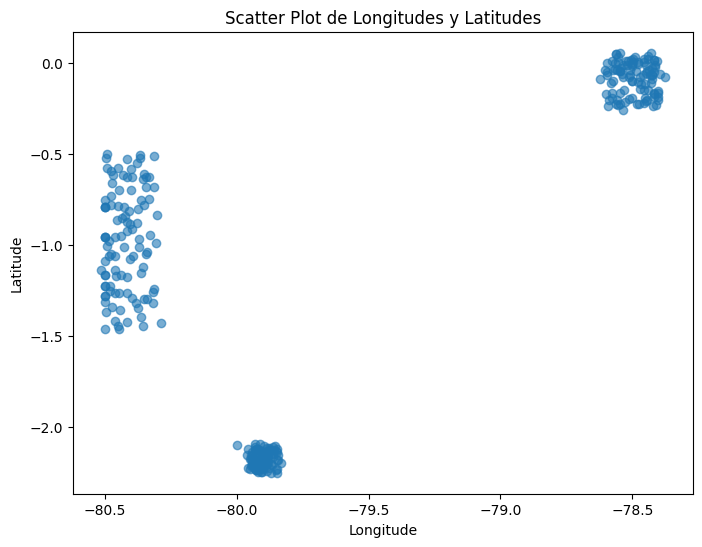

In [227]:
# Scatter plot para visualizar la distribución de las variables
plt.figure(figsize=(8,6))
plt.scatter(df_temp['Longitude'], df_temp['Latitude'], alpha=0.6)

plt.title('Scatter Plot de Longitudes y Latitudes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


# Gráfico de correlación (heatmap)


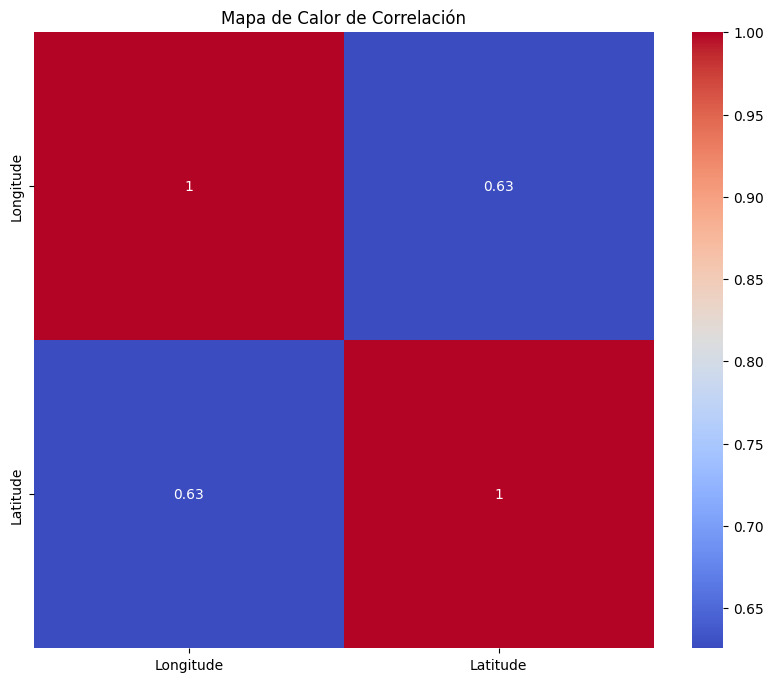

In [228]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')
plt.show()

Existe correlación entre las variables.

#   Visualizaciones

<Figure size 1600x1000 with 0 Axes>

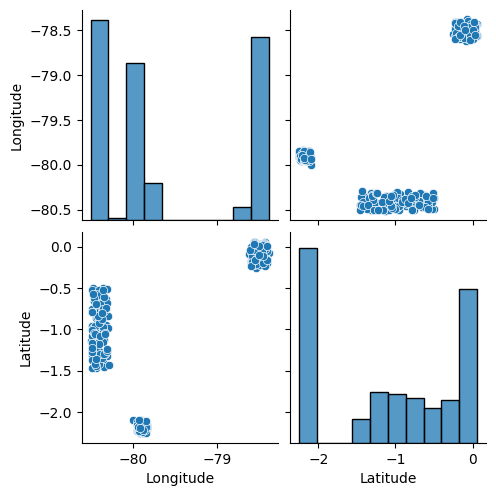

In [229]:
cluster_cols = ['Longitude', 'Latitude']

plt.figure(1, figsize=(16,10))
sns.pairplot(data=df_temp[cluster_cols])
plt.show()

# Encontrar el número adecuado de clusters usando el método del codo y Silhouette Score


Como tiene valores nulos todavia, se va a hacer la clusterización considerando solo la columna con todos los datos. Latitude

In [230]:
cluster_cols = ['Latitude','Latitude']

In [231]:
# Método del Codo
sse = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_temp)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_temp, kmeans.labels_))

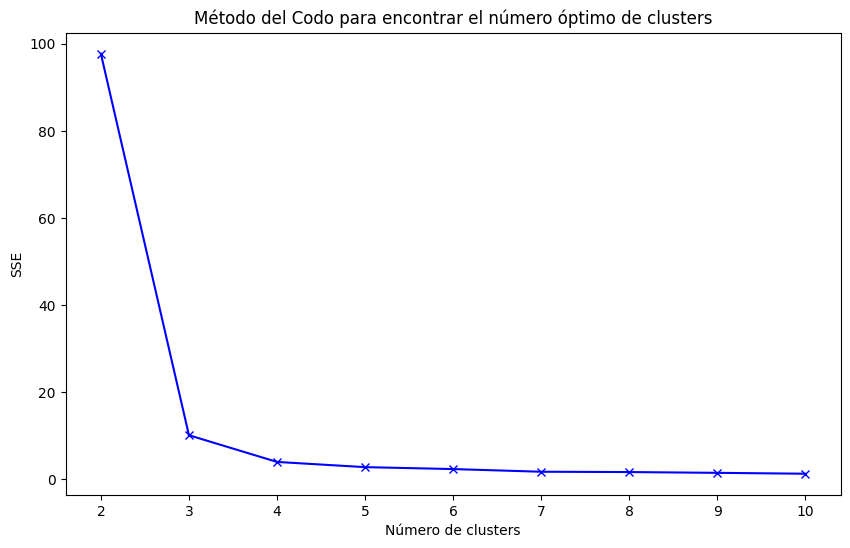

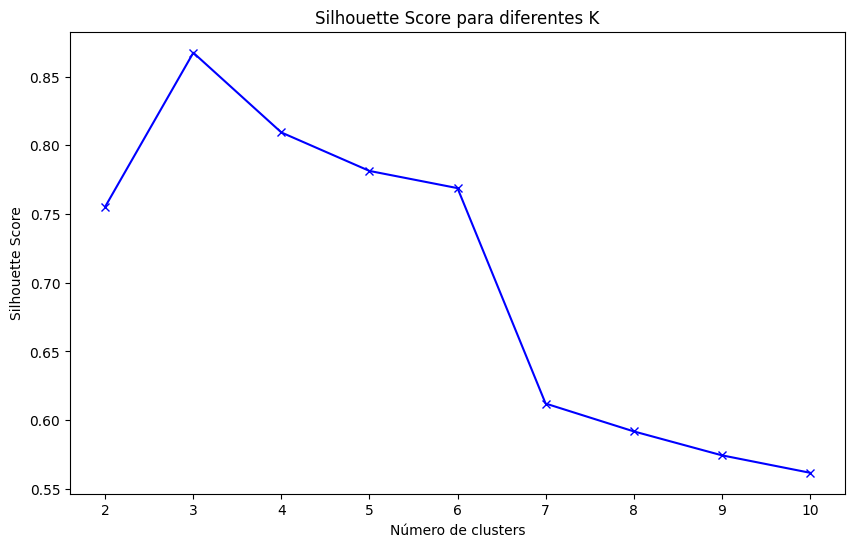

In [232]:
# Gráfico del método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K, sse, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del Codo para encontrar el número óptimo de clusters')
plt.show()

# Gráfico del Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes K')
plt.show()

In [233]:
# Aplicar KMeans y K-Medoids (K-Medians)
optimal_k = 3  # Elegido basado en los gráficos

# Aplicar KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_temp)

# Aplicar K-Medoids (aproximación a K-Medians)
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42)
kmedoids_labels = kmedoids.fit_predict(df_temp)

In [234]:
# Evaluación de los clusters
kmeans_silhouette = silhouette_score(df_temp, kmeans_labels)
kmedoids_silhouette = silhouette_score(df_temp, kmedoids_labels)

print(f"\nSilhouette Score para KMeans: {kmeans_silhouette}")
print(f"Silhouette Score para KMedoids: {kmedoids_silhouette}")

# Visualización de los clusters (solo si hay dos dimensiones o reducimos a dos con PCA)



Silhouette Score para KMeans: 0.8673530934558298
Silhouette Score para KMedoids: 0.8673530934558298


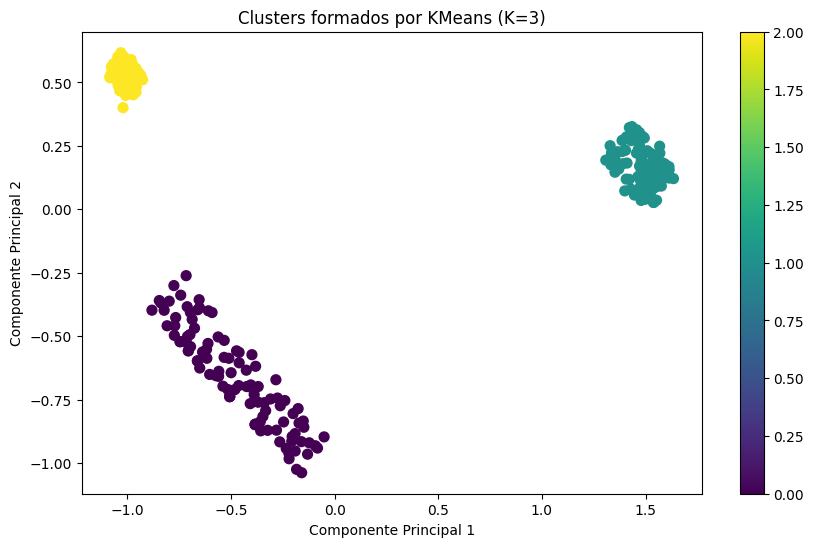

In [235]:
from sklearn.decomposition import PCA

# Reducir dimensiones para visualizar los clusters
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_temp)

# Visualizar los clusters de KMeans
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title(f'Clusters formados por KMeans (K={optimal_k})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar()
plt.show()

# Guardar los resultados de los clusters
df_temp['Cluster_Label'] = kmeans_labels


In [236]:
df_temp["Cluster_Label"].value_counts()

,count
Cluster_Label,
0,104
1,101
2,100


In [237]:
df_entregable = df_temp[["Cluster_Label"]]

In [238]:
# Guardar el archivo con los clusters
df_entregable.to_csv('clusters.txt', sep='\t', index=True)